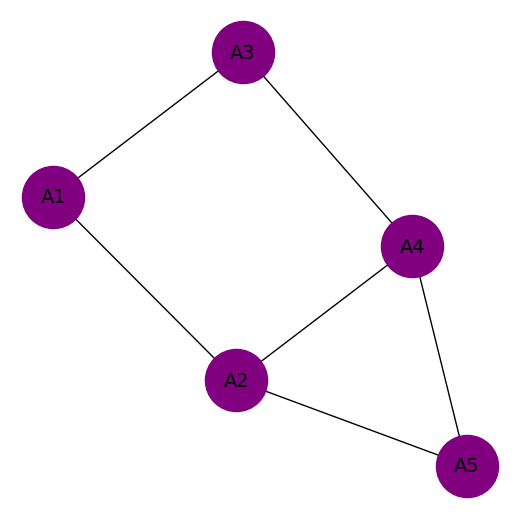

['A1', 'A3']
['A1', 'A2']
['A4', 'A3']
['A4', 'A2', 'A5']


In [ ]:
#ex1

#a

import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import MarkovNetwork

model = MarkovNetwork()
edges = [("A1", "A2"), ("A1", "A3"), ("A2", "A4"), ("A2", "A5"), ("A3", "A4"), ("A4", "A5")]
model.add_edges_from(edges)

G = nx.Graph()
G.add_nodes_from(model.nodes())
G.add_edges_from(model.edges())

plt.figure(figsize=(5, 5))


In [ ]:
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='purple', node_size=2000, font_size=14)
plt.show()

cliques = list(nx.find_cliques(G))
for c in cliques:
    print(c)


In [11]:
#b

import itertools
import numpy as np

variables = ["A1", "A2", "A3", "A4", "A5"]
states = [-1, 1]

cliques = [
    ['A1', 'A3'], ['A1', 'A2'], ['A4', 'A3'], ['A4', 'A2', 'A5']
]

def phi(clique, assignment):
    exp_sum = sum(int(v[1]) * assignment[v] for v in clique)
    return np.exp(exp_sum)

results = []
for combo in itertools.product(states, repeat=5):
    assign = dict(zip(variables, combo))
    potential = np.prod([phi(c, assign) for c in cliques])
    results.append((assign, potential))

Z = sum(r[1] for r in results)
probs = [(r[0], r[1] / Z) for r in results]

best_state = max(probs, key=lambda x: x[1])
print("Best", best_state[0])
print("Prob", best_state[1])


Best {'A1': 1, 'A2': 1, 'A3': 1, 'A4': 1, 'A5': 1}
Prob 0.9816337633672501


In [5]:
#ex 2

#crearea de imagini

import os
import random
import numpy as np
from PIL import Image

H, W = 5, 5
noise_frac = 0.10
lambda_reg = 2.0
pairwise_beta = 1.0
seed = 0

random.seed(seed)
np.random.seed(seed)

out_dir = "C:/Users/vitor/Desktop/Facultate/PMP/PMP-2025/Lab04"
os.makedirs(out_dir, exist_ok=True)

original = np.zeros((H, W), dtype=np.uint8)
noisy = original.copy()
flip_positions = [(1, 1), (2, 2), (3, 3), (0, 0)]
for pos in flip_positions:
    noisy[pos] = 1 - noisy[pos]

orig_path = os.path.join(out_dir, "original.png")
noisy_path = os.path.join(out_dir, "noisy.png")
Image.fromarray(original*255).save(orig_path)
Image.fromarray(noisy*255).save(noisy_path)


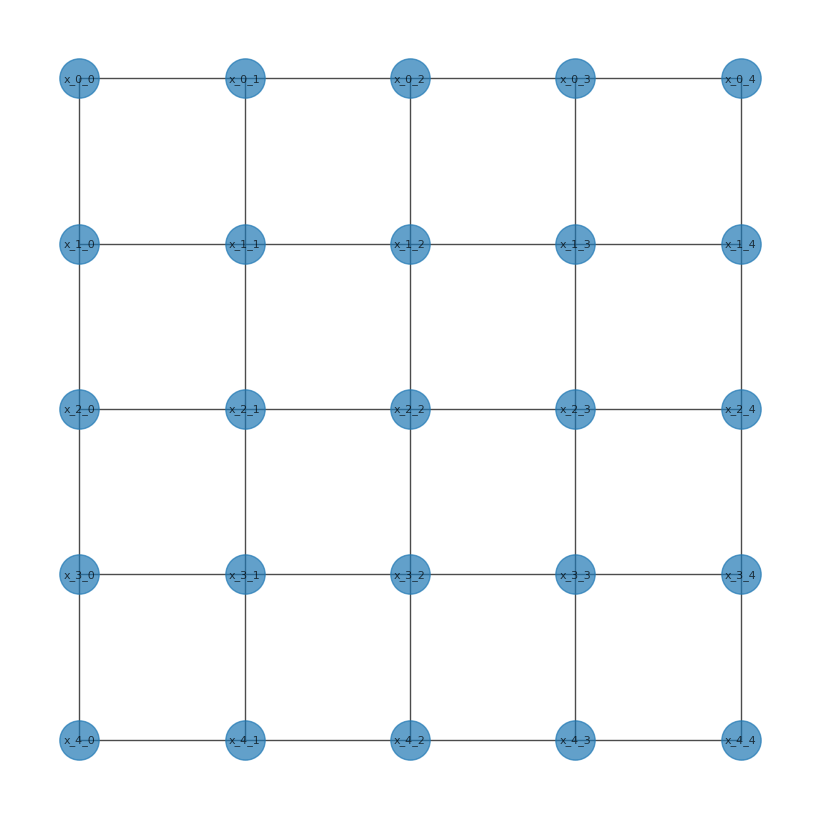

Nr factori 65

imaginea fara noise
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]

acuratete 1.0


In [ ]:
#a

import numpy as np
from pgmpy.models import MarkovNetwork
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.inference import BeliefPropagation
import networkx as nx
import matplotlib.pyplot as plt

H, W = 5, 5
model = MarkovNetwork()

for i in range(H):
    for j in range(W):
        node_name = "x_" + str(i) + "_" + str(j)
        model.add_node(node_name)

edges = []
for i in range(H):
    for j in range(W):
        if j < W - 1:
            node1 = "x_" + str(i) + "_" + str(j)
            node2 = "x_" + str(i) + "_" + str(j+1)
            edges.append((node1, node2))
        if i < H - 1:
            node1 = "x_" + str(i) + "_" + str(j)
            node2 = "x_" + str(i+1) + "_" + str(j)
            edges.append((node1, node2))

model.add_edges_from(edges)

pos = {}
for i in range(H):
    for j in range(W):
        node_name = "x_" + str(i) + "_" + str(j)
        pos[node_name] = (j, -i)

plt.figure(figsize=(8, 8))
nx.draw(model, pos=pos, with_labels=True, alpha=0.7, node_size=800, font_size=8)
plt.show()

factors = []
lambda_reg = 2.0

for i in range(H):
    for j in range(W):
        node_name = "x_" + str(i) + "_" + str(j)
        observed_val = noisy[i, j]
        
        if observed_val == 0:
            black_prob = 1.0
            white_prob = np.exp(-lambda_reg)
        else:
            black_prob = np.exp(-lambda_reg)
            white_prob = 1.0
        
        factor = DiscreteFactor(
            variables=[node_name],
            cardinality=[2],
            values=[black_prob, white_prob]
        )
        factors.append(factor)

for edge in edges:
    node1, node2 = edge
    same_color_prob = 1.0
    diff_color_prob = np.exp(-3.0)
    
    factor = DiscreteFactor(
        variables=[node1, node2],
        cardinality=[2, 2],
        values=[
            [same_color_prob, diff_color_prob],
            [diff_color_prob, same_color_prob]]
    )
    factors.append(factor)

model.add_factors(*factors)

print("nr factori " + str(len(model.get_factors())))

bp_infer = BeliefPropagation(model)

variables = []
for i in range(H):
    for j in range(W):
        node_name = "x_" + str(i) + "_" + str(j)
        variables.append(node_name)

marginals = bp_infer.map_query(variables=variables)

denoised = np.zeros_like(noisy)
for i in range(H):
    for j in range(W):
        node_name = "x_" + str(i) + "_" + str(j)
        denoised[i, j] = marginals[node_name]

print("\nimaginea fara noise")
print(denoised)

correct_pixels = 0
total_pixels = H * W
for i in range(H):
    for j in range(W):
        if denoised[i, j] == original[i, j]:
            correct_pixels += 1

accuracy = correct_pixels / total_pixels
print("\nacuratete " + str(round(accuracy, 3)))
